In [38]:
import lsdb
print(lsdb.__version__)
import hats
print(hats.__version__)
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from nested_pandas import NestedDtype

import nested_pandas as npd

0.5.3.dev6+gfc62489
0.5.3.dev2+g9f35663


In [ ]:
comcam_x_milliquas_computed.to_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The output file path


In [39]:
comcam_x_milliquas_computed = npd.read_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The input file path

In [40]:
comcam_x_milliquas_computed

diaObjectId_COM     ra_COM    dec_COM  nDiaSources_COM  \
0    4601816802056470555   37.78485   6.401707                9   
1    4602278596940136493  38.493226   6.427911                2   
..                   ...        ...        ...              ...   
175  1766616118673277889  39.903773 -34.358387                6   
176  1766616118673278246  39.954222 -34.333328                1   

     radecMjdTai_COM  tract_COM  \
0       60643.083293      10463   
1       60638.131253      10464   
..               ...        ...   
175     60650.179955       4016   
176     60639.270055       4016   

                                         diaSource_COM  \
0    [{visit: 2024112300214, detector: 8, band: 'r'...   
1    [{visit: 2024112300221, detector: 5, band: 'r'...   
..                                                 ...   
175  [{visit: 2024112400239, detector: 4, band: 'r'...   
176  [{visit: 2024112400274, detector: 4, band: 'i'...   

                             diaObjectForcedSource_COM     RA_MIL    DEC_MIL  \
0    [{parentObjectId: 0, coord_ra: 37.78485, coord...  37.784846   6.401708   
1    [{parentObjectId: 0, coord_ra: 38.493226, coor...  38.493228    6.42792   
..                                                 ...        ...        ...   
175  [{parentObjectId: 0, coord_ra: 39.903773, coor...  39.903809 -34.358342   
176  [{parentObjectId: 0, coord_ra: 39.954222, coor...  39.954219 -34.333329   

     ... B_MIL  Z_MIL  CITE_MIL  ZCITE_MIL               XNAME_MIL  \
0    ...     -  1.404    LAMQ5      LAMQ5                            
1    ...     -  3.932    LAMQ5      LAMQ5                            
..   ...   ...    ...       ...        ...                     ...   
175  ...     1  0.203    1863       1863                             
176  ...     1  0.325    1863       1863    4XMM J023949.0-341959    

                  RNAME_MIL               LOBE1_MIL               LOBE2_MIL  \
0                                                                             
1    VLAJ023358.35+062540.6  FIRST J023358.3+062540  RACS J023358.4+062541    
..                      ...                     ...                     ...   
175                                                                           
176                                                                           

    _dist_arcsec          _healpix_29  
0       0.013628     9583286184991586  
1       0.033737     9589207111731798  
..           ...                  ...  
175     0.191274  2531133149718993894  
176     0.011135  2531133272813443525  

[177 rows x 26 columns]

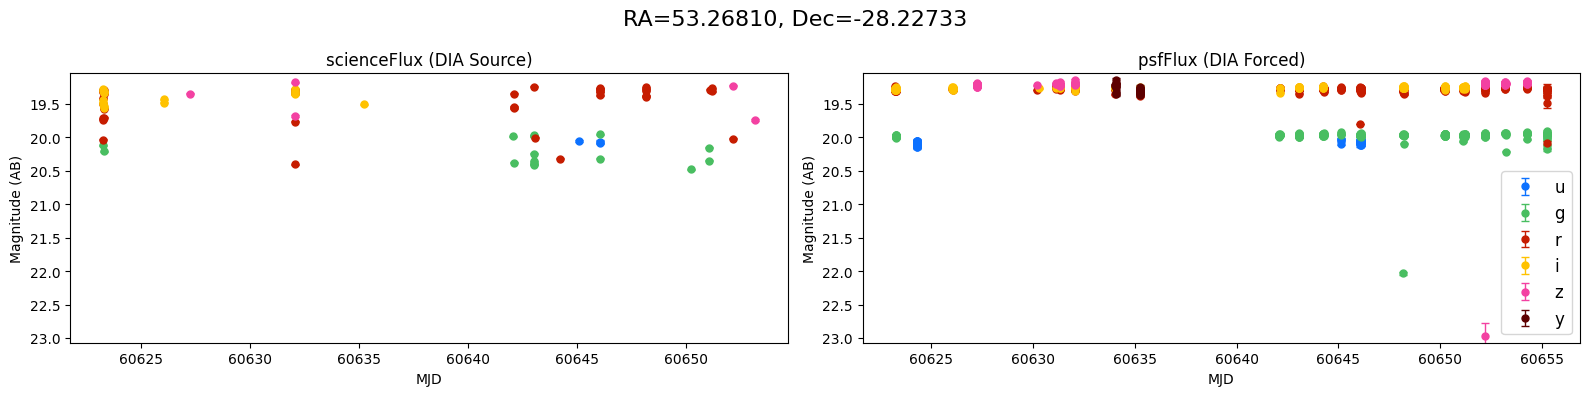

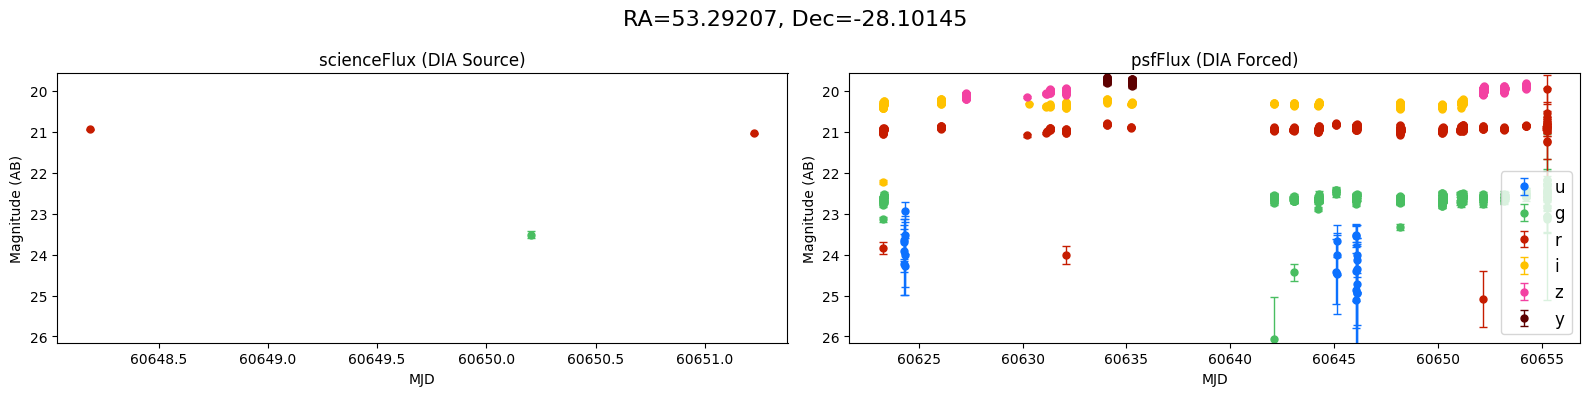

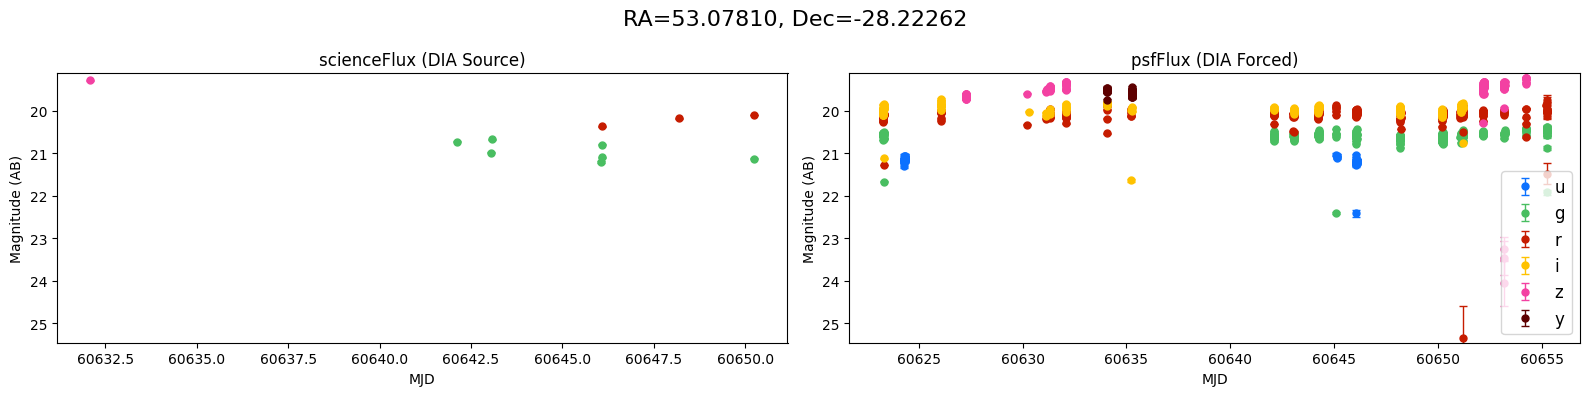

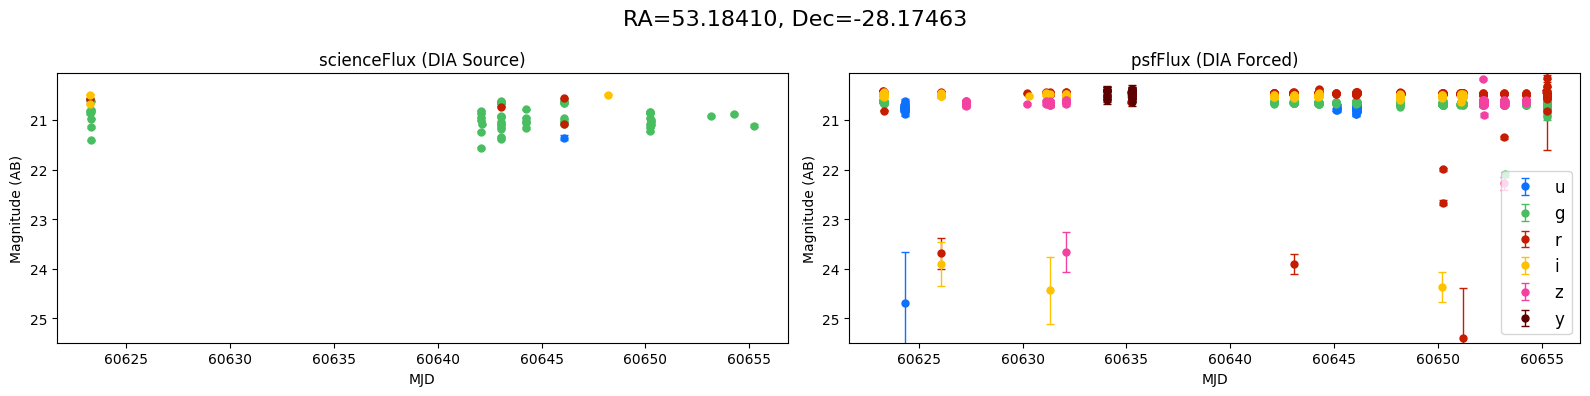

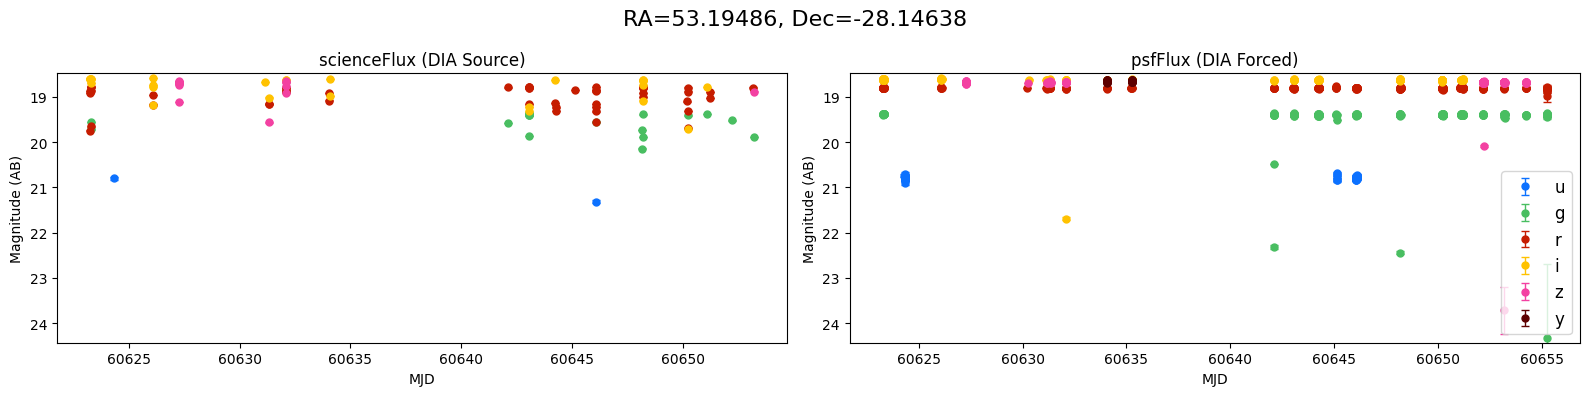

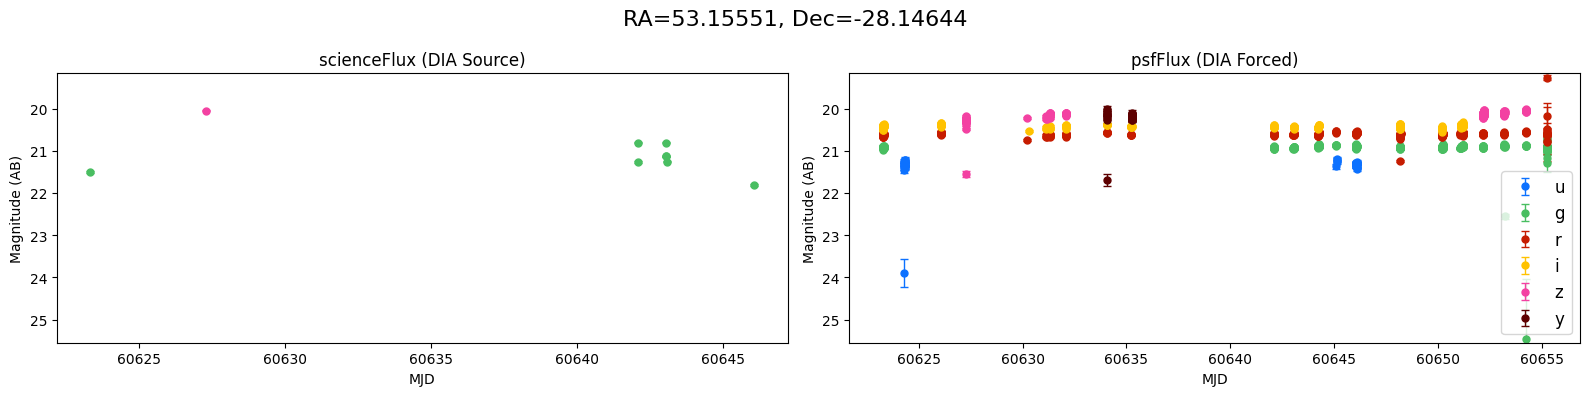

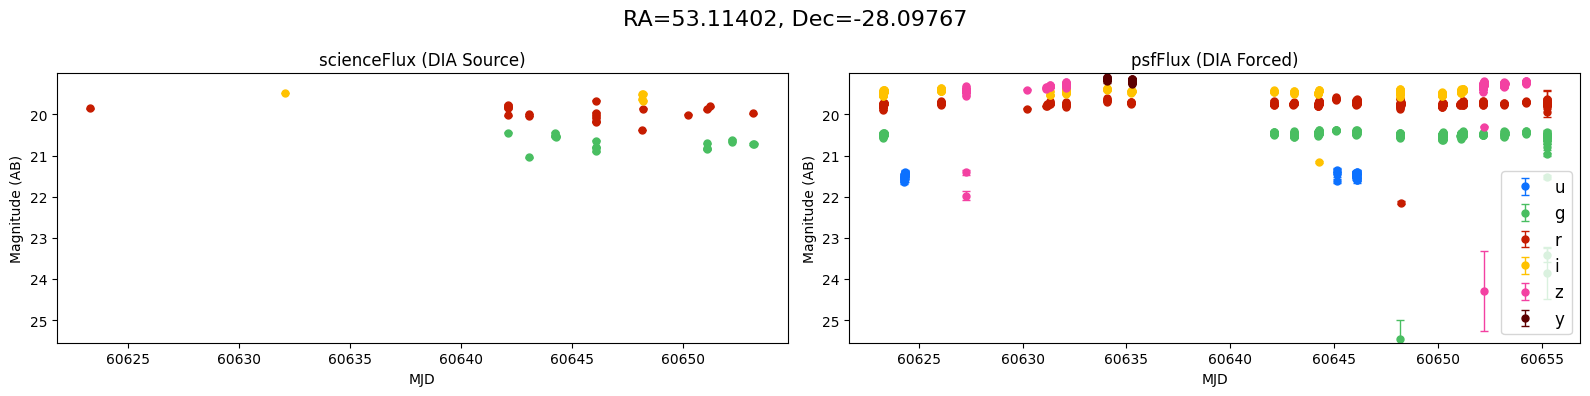

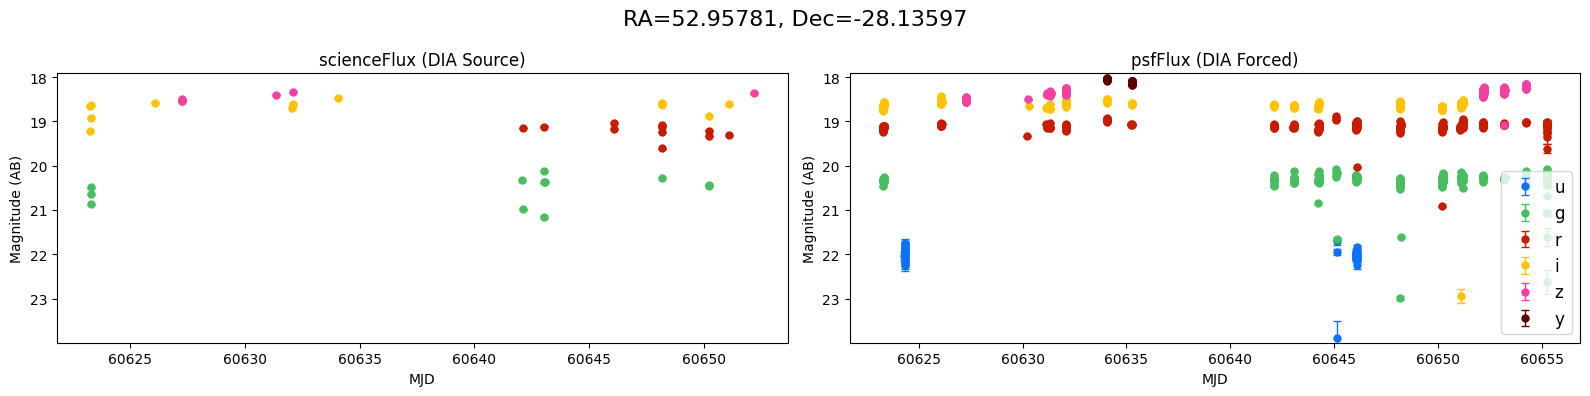

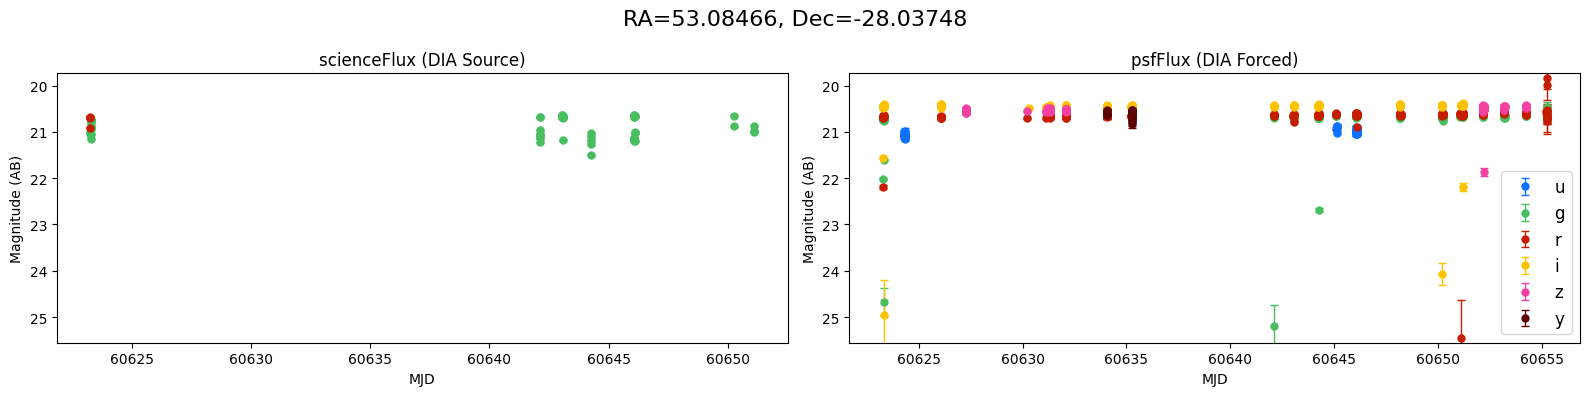

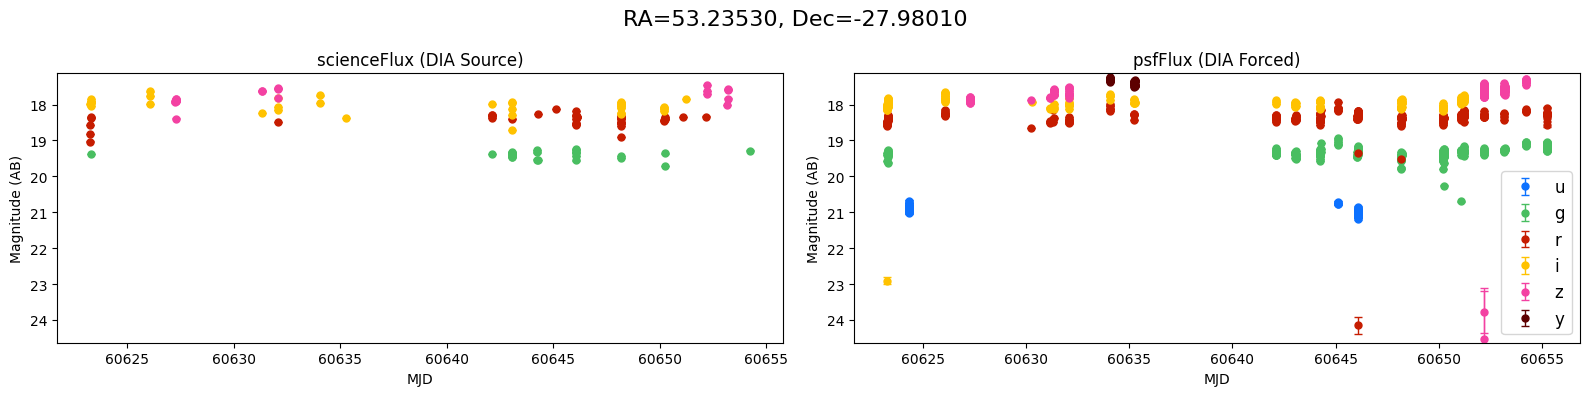

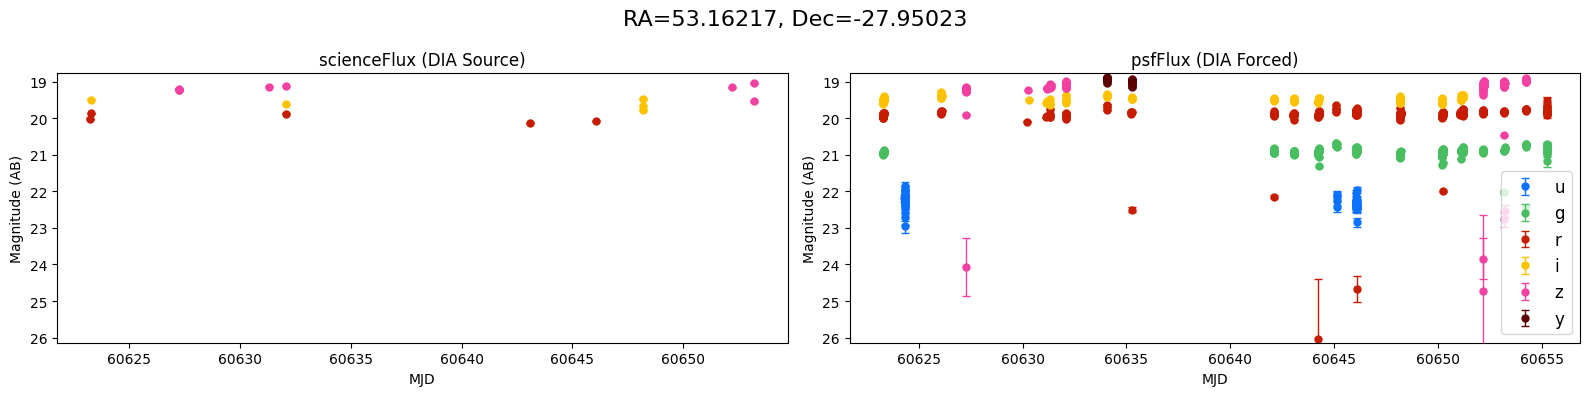

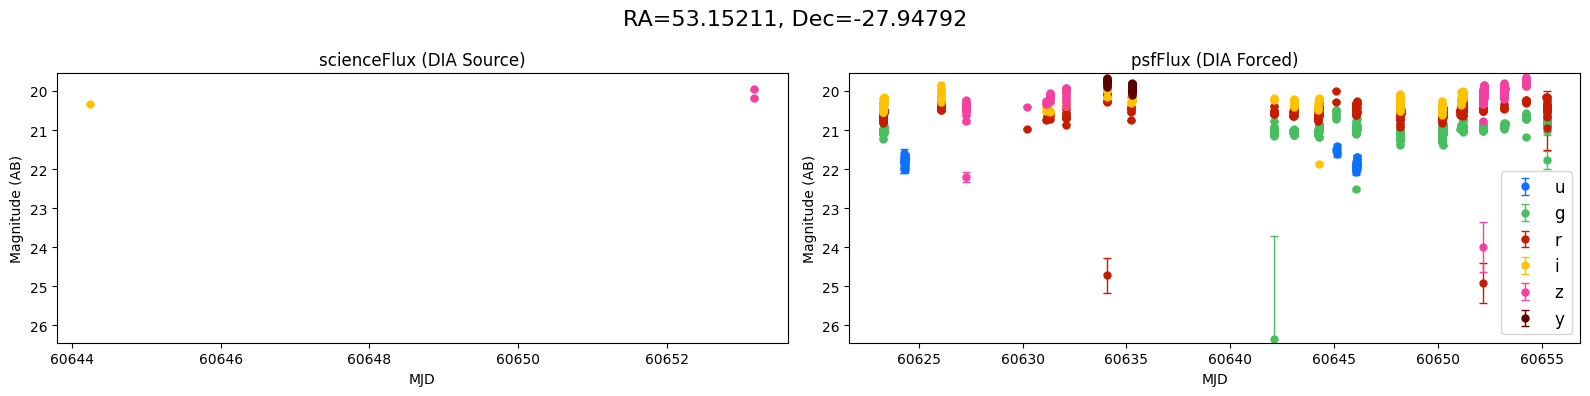

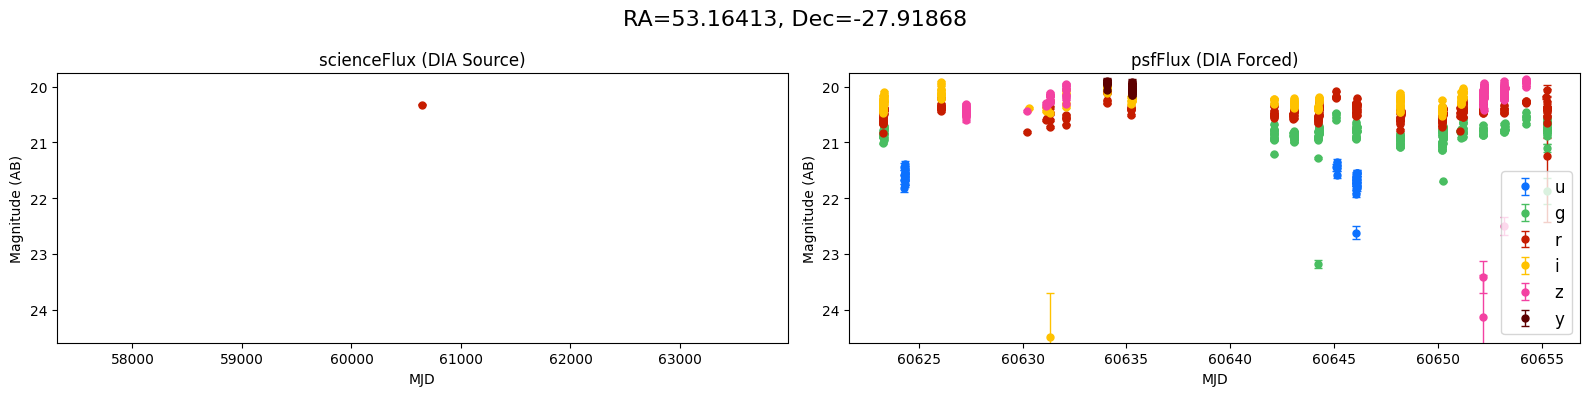

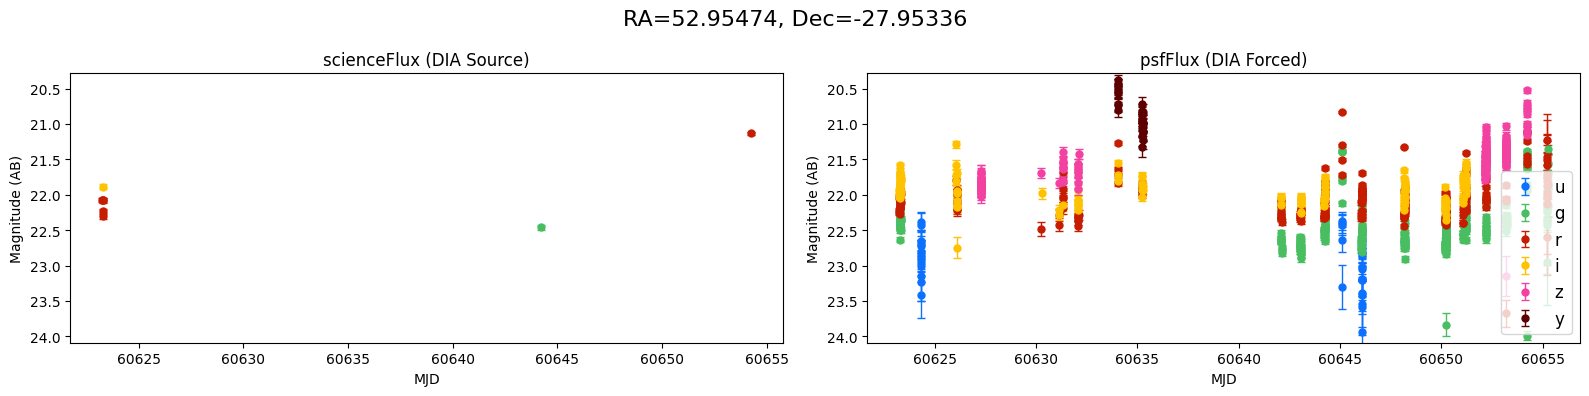

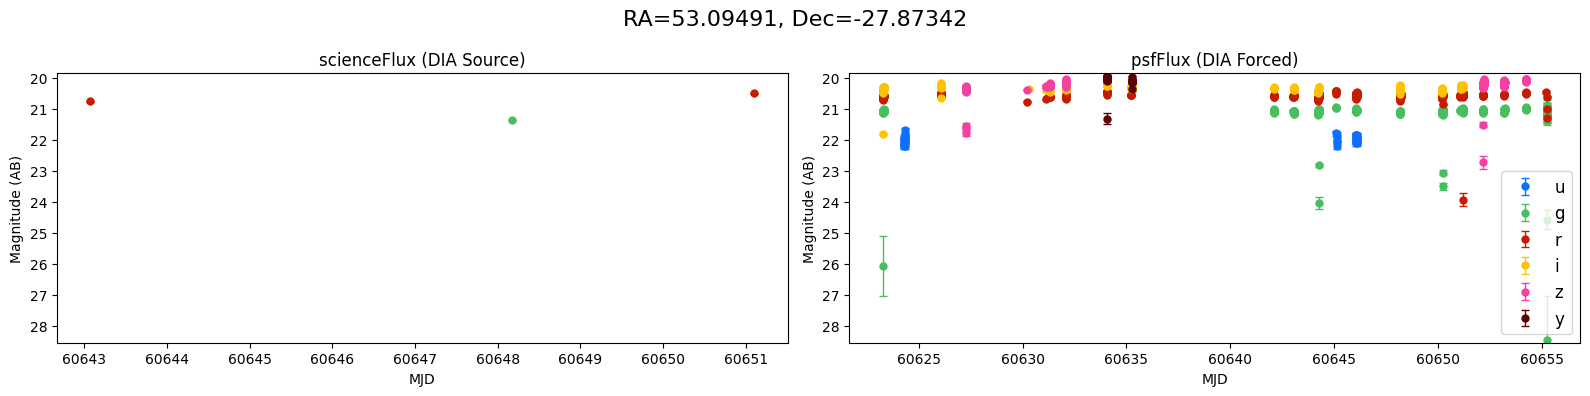

In [76]:
COLORS = {'u': '#0c71ff',
 'g': '#49be61',
 'r': '#c61c00',
 'i': '#ffc200',
 'z': '#f341a2',
 'y': '#5d0000'}

def create_mag_errors(flux, flux_err):
    # Make sure everything is valid and flux ± err stays positive
    upper = flux + flux_err
    lower = flux - flux_err
    mask = (
        flux.notna()
        & flux_err.notna()
        & (flux > 0)
        & (upper > 0)
        & (lower > 0)
    )

    # Initialize with NaNs
    mag = np.full_like(flux, np.nan, dtype=float)
    mag_err = np.full_like(flux, np.nan, dtype=float)

    # Apply the AB mag conversion only to valid values
    valid_flux = flux[mask]
    valid_err = flux_err[mask]

    mag[mask] = u.nJy.to(u.ABmag, valid_flux)
    upper_mag = u.nJy.to(u.ABmag, valid_flux + valid_err)
    lower_mag = u.nJy.to(u.ABmag, valid_flux - valid_err)
    mag_err[mask] = -(upper_mag - lower_mag) / 2

    return pd.Series(mag, index=flux.index), pd.Series(mag_err, index=flux.index)

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    mag_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, mag_err = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            mag_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_vals.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)
    return mag_vals

def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        ymin, ymax = np.nanmin(all_mags[0]), np.nanmax(all_mags[0])
        for i in range(2):
            ax[0, i].set_ylim(ymax + 0.1, ymin - 0.1)

"""            
def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        # Flatten, drop NaNs, compute median
        mags = np.array(all_mags[0])
        mags = mags[np.isfinite(mags)]
        if len(mags) > 0:
            median_mag = np.median(mags)
            for i in range(2):
                ax[0, i].set_ylim(median_mag + 0.5, median_mag - 0.5)
"""
def plot_mag_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_mags = [[], []]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_mags[0].extend(
            plot_mag_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 1))
        )
    return all_mags

# Now plot
for i in range(len(comcam_AGN_many_r)):
    row = comcam_AGN_many_r.iloc[i]
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))  # Just one row now
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_mags = plot_mag_lightcurves(np.expand_dims(ax, 0), row)  # Make ax 2D for consistency
    scale_mag_y_axis(np.expand_dims(ax, 0), all_mags)
    plt.tight_layout()
    plt.show()

In [65]:

def calcSF(tclip, fclip, nbins=10):
    """
    Compute the structure function (SF) using bins with equal number of time-lagged pairs.

    Parameters
    ----------
    tclip : ndarray
        1D array of time values (sorted).
    fclip : ndarray
        1D array of flux or magnitude values.
    nbins : int
        Number of bins, each with equal number of pairs.

    Returns
    -------
    tau_median : ndarray
        Median time lag in each bin.
    SF : ndarray
        Structure function values.
    N : ndarray
        Number of pairs in each bin (should be ~equal).
    """
    dt_list = []
    df2_list = []

    for i in range(len(tclip)):
        dt = tclip[i+1:] - tclip[i]
        df2 = (fclip[i+1:] - fclip[i])**2
        dt_list.append(dt)
        df2_list.append(df2)

    all_dt = np.concatenate(dt_list)
    all_df2 = np.concatenate(df2_list)

    # Sort by time difference
    sorted_indices = np.argsort(all_dt)
    all_dt = all_dt[sorted_indices]
    all_df2 = all_df2[sorted_indices]

    total_pairs = len(all_dt)
    pairs_per_bin = total_pairs // nbins

    tau_median = []
    SF = []
    N = []

    for i in range(nbins):
        start = i * pairs_per_bin
        end = (i + 1) * pairs_per_bin if i < nbins - 1 else total_pairs
        dt_bin = all_dt[start:end]
        df2_bin = all_df2[start:end]

        if len(df2_bin) > 0:
            tau_median.append(np.median(dt_bin))
            SF.append(np.sqrt(np.mean(df2_bin)))
            N.append(len(df2_bin))
        else:
            tau_median.append(np.nan)
            SF.append(np.nan)
            N.append(0)

    return np.array(tau_median), np.array(SF), np.array(N)

In [73]:
len(row.diaObjectForcedSource_COM)

726

In [72]:
row.diaObjectForcedSource_COM[row.diaObjectForcedSource_COM['band'] == 'r']

,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceOnDiaObjectId,psfMag,psfMagErr,midpointMjdTai
0,0,53.09491,-27.873418,2024110800245,1,r,24837.423828,241.975174,False,636.792664,...,False,False,False,False,5063,24,190875481652860782,20.412233,0.010578,60623.258521
1,0,53.09491,-27.873418,2024110800246,1,r,20071.171875,179.688263,False,112.363625,...,False,False,False,False,5063,24,190875482726602673,20.643568,0.009720,60623.259329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,53.09491,-27.873418,2024121000433,2,r,13589.772461,1077.794067,False,404.807098,...,False,False,False,False,5063,24,192001583427355632,21.066969,0.086290,60655.249581
725,0,53.09491,-27.873418,2024121000434,2,r,13576.779297,559.793579,False,-327.085205,...,False,False,False,False,5063,24,192001584501097335,21.068008,0.044792,60655.249976


In [66]:
tau, SF, N = calcSF(row.diaObjectForcedSource_COM['midpointMjdTai'].values, row.diaObjectForcedSource_COM['psfMag'].values, 10)
# Now we can use the function to compute the structure function for a light curve

In [69]:
tau, SF, N

(array([2.56352256e-02, 1.95506784e+00, 3.02842172e+00, 5.02888343e+00,
        7.15822340e+00, 9.96598730e+00, 1.49192852e+01, 1.91508831e+01,
        2.30858953e+01, 2.79625708e+01]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([26317, 26317, 26317, 26317, 26317, 26317, 26317, 26317, 26317,
        26322]))

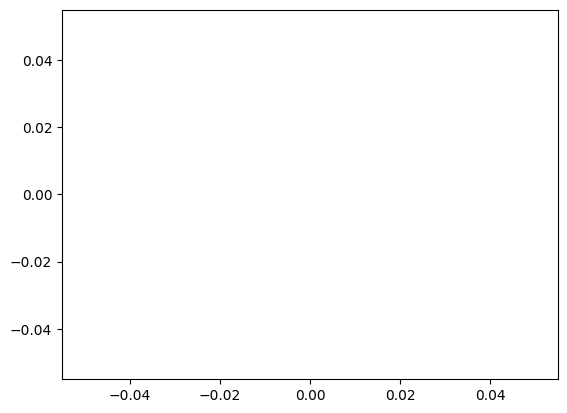

In [67]:
plt.plot(tau, SF, 'o')